#   [Py4Hw User Guide](../UserGuide.ipynb)> 11.3 HLS internals

High Level Synthesis is typically available to generate Verilog from C/C++.
On the contrary, we do Python Behavioral to Python Structural.

## Overview of the Process
- AST generation from code
- Control Data-Flow Graph generation from AST
- SSA Form

In [1]:
%%javascript
// Hide cells with 'hide-cell' tag
Jupyter.notebook.get_cells().forEach(cell => {
    if (cell.metadata.tags && cell.metadata.tags.includes("hide-cell")) {
        cell.element.show();
    }
});

<IPython.core.display.Javascript object>

## Example
Below there is a hidden cell with an example

In [2]:
import py4hw

class SquareRoot(py4hw.Logic):
    def __init__(self, parent, name, a, r):
        super().__init__(parent, name)
        
        self.a = self.addIn('a', a)
        self.r = self.addOut('r', r)
        
        
    def propagate(self):
        maxv = 1 << self.a.getWidth()
        maxiter = int(math.log2(math.log2(maxv))) + 4
        #print('max iters:', maxiter)
        
        n = self.a.get() 
        if n == 0:
            r = 0
        elif n == 1:
            r = 1
        else:
            guess = n
            done = False
            for _ in range(maxiter):
                # For a combinational circuit loops must be fully unrollable,
                # otherwise no synthesys is possible
                if (done):
                    pass
                else:
                    next_guess = (guess + (n // guess)) // 2  # Integer division

                    if next_guess >= guess:  # Convergence condition: guess stops decreasing
                        done = True
                    else:
                        guess = next_guess
            r = guess
            
        self.r.put(r)


In [3]:
%%javascript
// Hide cells with 'hide-cell' tag
Jupyter.notebook.get_cells().forEach(cell => {
    if (cell.metadata.tags && cell.metadata.tags.includes("hide-cell")) {
        cell.element.hide();
    }
});

<IPython.core.display.Javascript object>

## AST Generation
A great benefit from python is that it is very easy to get the AST from a code.
You don't need to implement your own parser and AST representation. All this is already part of the language.

We have encapsulated some methods to make it easy.

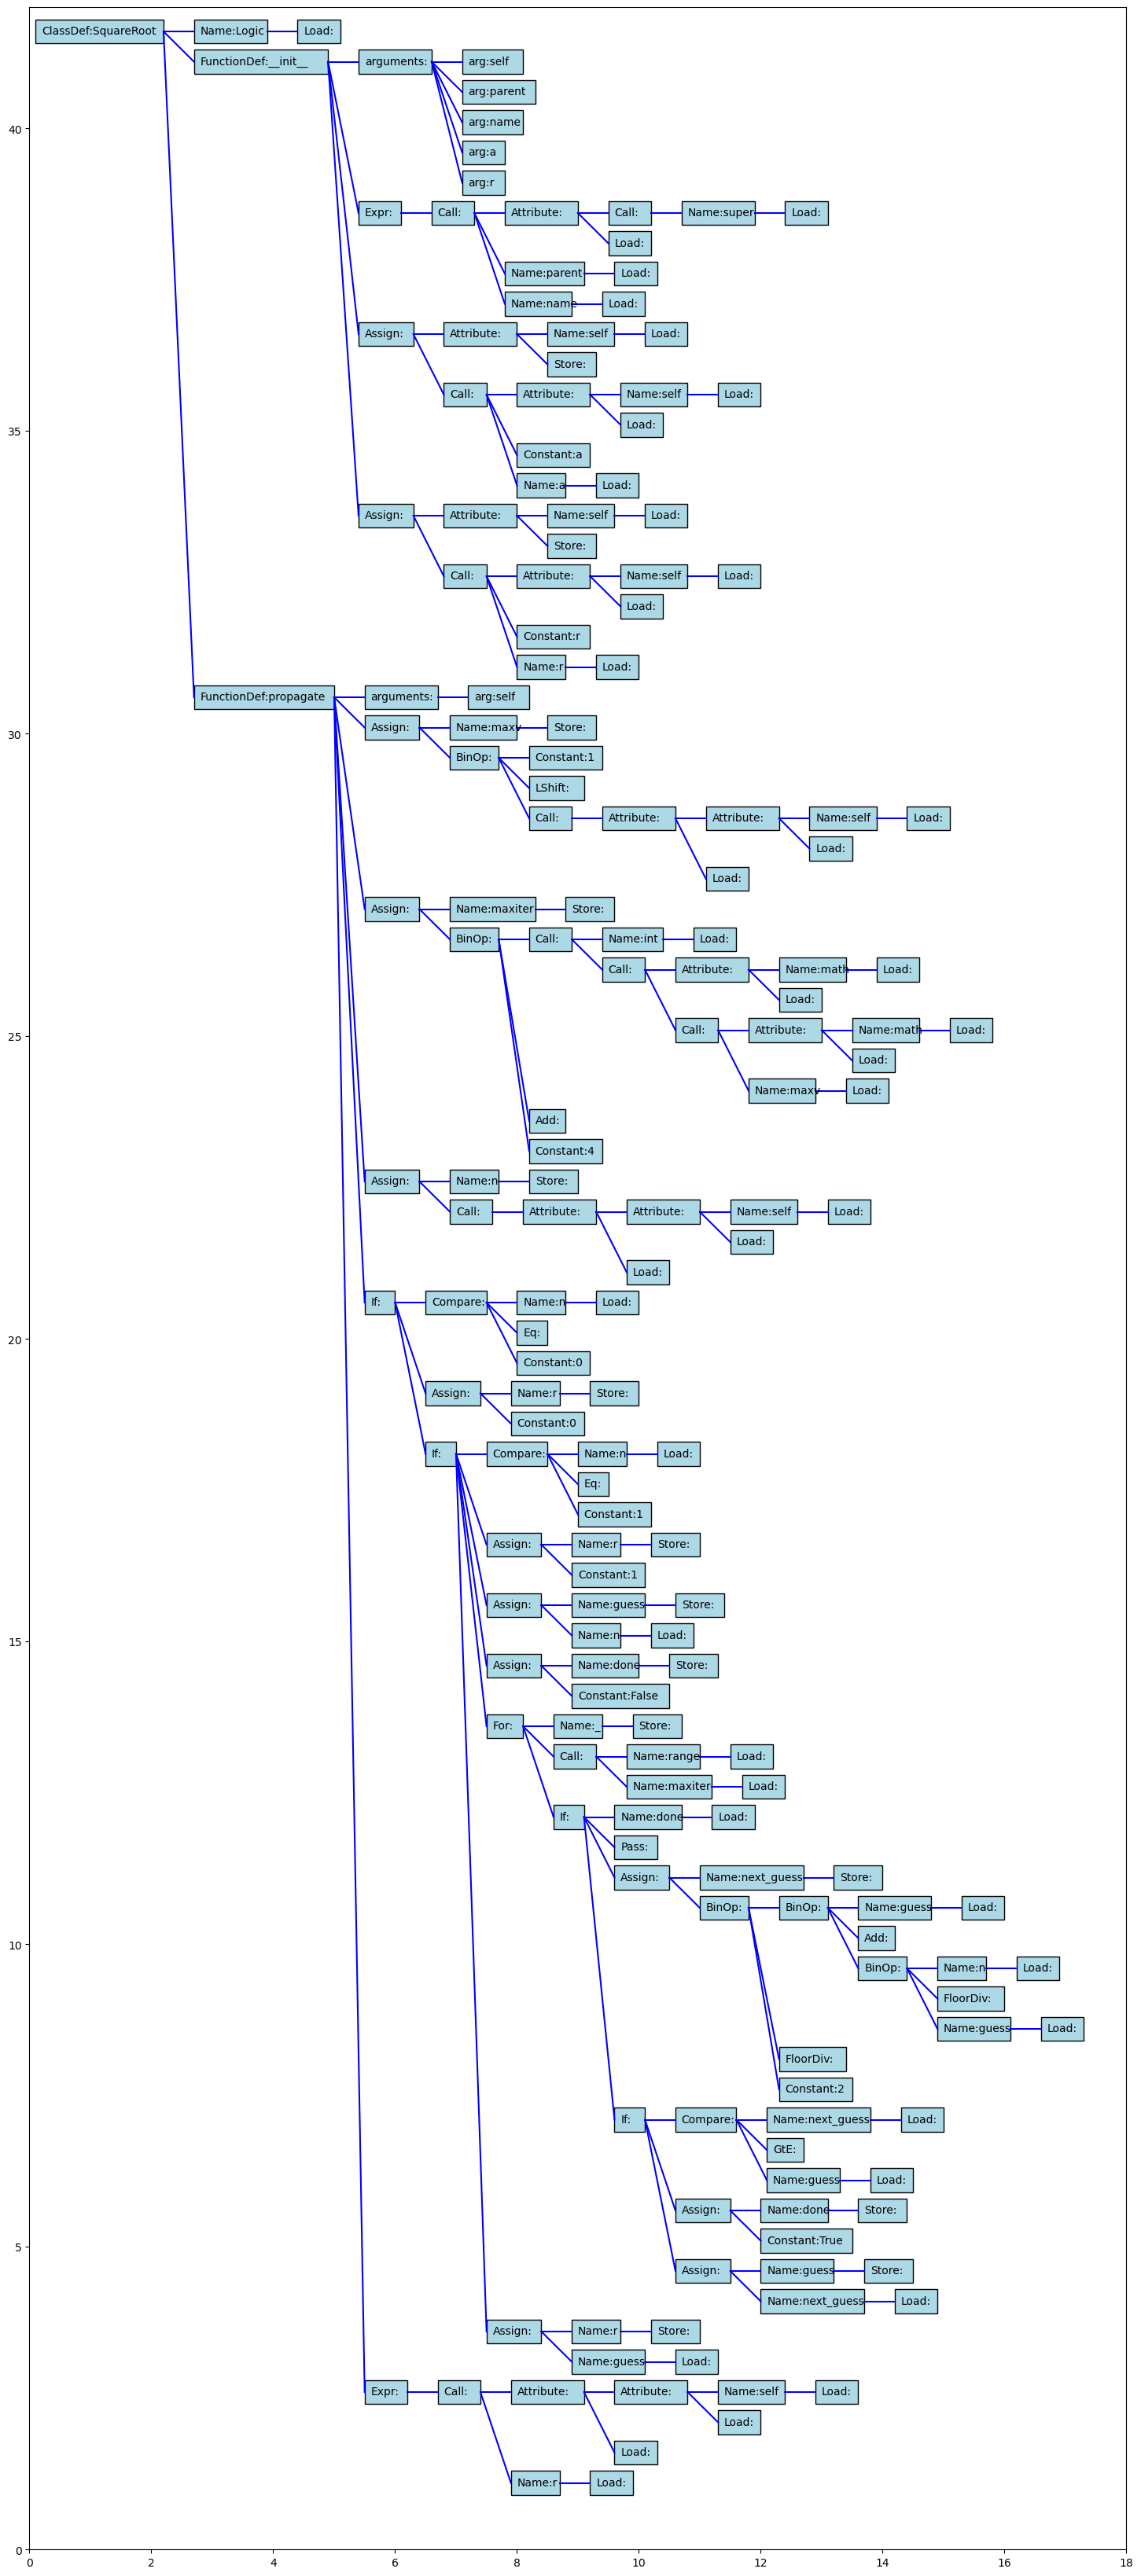

In [4]:
from py4hw.transpilation.astutils import *

tree = get_class_ast(SquareRoot)
ASTDrawer().draw_ast(tree)

## Control Data-Flow Graph generation from AST
The AST is analyzed to build a control data flow graph. In this graph we have Basic Blocks (BBs), that contain sequences of operations that are not affected by control operations.

Then, we have branch nodes, where flow can be diverted to several paths based on some condition. 

Finally, we have merge nodes, where several flows can join.

In [5]:
propagate_node =  getASTFromClassMethod(tree, 'propagate')
build = CFGBuilder()
build.build(propagate_node)

closing open blocks in BB8 to next BB11
closing open blocks in BB6 to next BB12
closing open blocks in BB2 to next BB14
closing open blocks in BB0 to next BB15


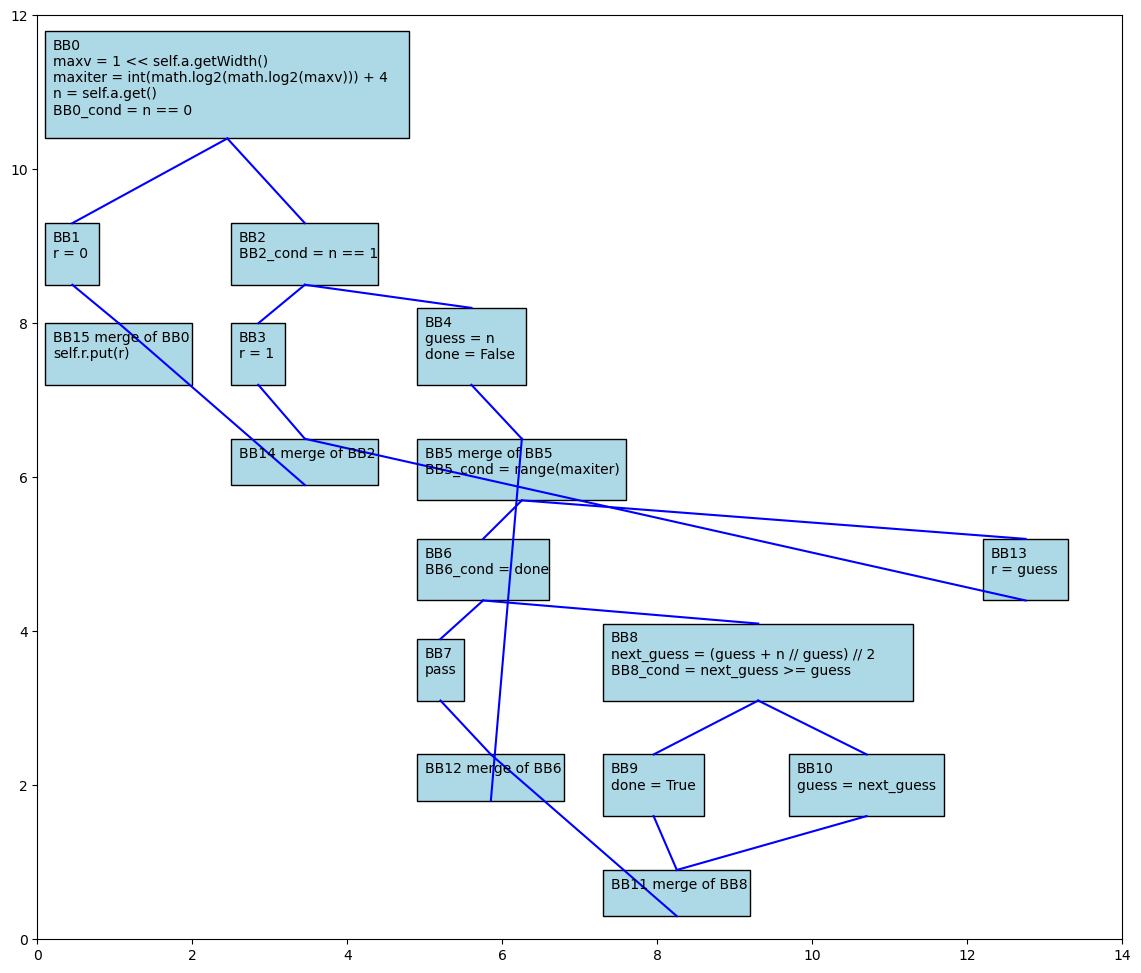

In [6]:
build.draw()


## SSA Form
We want to transform the code that we got after building the CDFG by static single assignment form.

We can traverse the graph and assign a variable name for every variable new assignment.

In merge nodes, we have to select the last value of the variable from every branch.

To do this, we need to have a mapping of the variable name with the list of variables in the BB.

We also need a clever way to traverse the graph, because we should not visit merge nodes until we have visited their incoming branches. How can we do it ?

In [7]:
# let's traverse the graph

to_visit = [build.entry]
visited = []

def append_to_visit(to_visit, node):
    to_visit.append(node)
    
def pop_to_visit(to_visit):
    # Find first non-merge node
    for i in range(len(to_visit)):
        node = to_visit[i]
        if (node.mergeofid == -1):
            to_visit.remove(node)
            return node
        
    # no non-merge node found, find last merge node    
    return to_visit.pop()

while len(to_visit) > 0:
    node = pop_to_visit(to_visit)
    visited.append(node)
    print(f'visiting BB{node.id} entries:', end='')
    
    for entry in node.entries:
        found = '-'
        if (entry.source in visited):
            found = 'OK'
        print(f'BB{entry.source.id}={found}', end=' ')
    
    print()
    
    for exit in node.exits:
        newnode = exit.target
        if not(newnode in visited):
            append_to_visit(to_visit, newnode)

visiting BB0 entries:
visiting BB1 entries:BB0=OK 
visiting BB2 entries:BB0=OK 
visiting BB3 entries:BB2=OK 
visiting BB4 entries:BB2=OK 
visiting BB5 entries:BB4=OK BB12=- 
visiting BB6 entries:BB5=OK 
visiting BB13 entries:BB5=OK 
visiting BB7 entries:BB6=OK 
visiting BB8 entries:BB6=OK 
visiting BB9 entries:BB8=OK 
visiting BB10 entries:BB8=OK 
visiting BB11 entries:BB9=OK BB10=OK 
visiting BB12 entries:BB7=OK BB11=OK 
visiting BB11 entries:BB9=OK BB10=OK 
visiting BB12 entries:BB7=OK BB11=OK 
visiting BB14 entries:BB3=OK BB13=OK 
visiting BB15 entries:BB1=OK BB14=OK 
visiting BB14 entries:BB3=OK BB13=OK 
visiting BB15 entries:BB1=OK BB14=OK 


This looks OK because BB5 is the for loop.
Let's try to collect assigned variables. Basically we identify them because there is an assignment to a name. 

In [8]:
for block in build.blocks:
    for st in block.st:
        if (isinstance(st, ast.Assign)):
            print(ast.unparse(st))

maxv = 1 << self.a.getWidth()
maxiter = int(math.log2(math.log2(maxv))) + 4
n = self.a.get()
BB0_cond = n == 0
r = 0
BB2_cond = n == 1
r = 1
guess = n
done = False
BB5_cond = range(maxiter)
BB6_cond = done
next_guess = (guess + n // guess) // 2
BB8_cond = next_guess >= guess
done = True
guess = next_guess
r = guess


In [9]:
class AssignedVariableExtractor(ast.NodeVisitor):
    variables = {}
    in_loop = False
    
    def visit_For(self, node):
        self.in_loop = True
        self.generic_visit(node)
        self.in_loop = False

    def visit_While(self, node):
        self.in_loop = True
        self.generic_visit(node)
        self.in_loop = False

        
    def visit_Assign(self, node):
        if (len(node.targets) != 1):
            raise Exception('We only support 1 assign target')
            
        target = node.targets[0]
        
        if isinstance(target, ast.Name):
            n = 1
            
            if (self.in_loop):
                n = 2
                
            if (target.id in self.variables.keys()):
                n = self.variables[target.id] + 1
                
            self.variables[target.id] = n
        else:
            raise Exception(f'target {target} not supporteds')

In [10]:
varExtractor = AssignedVariableExtractor()

varExtractor.visit(propagate_node)

print(varExtractor.variables)

{'maxv': 1, 'maxiter': 1, 'n': 1, 'r': 3, 'guess': 2, 'done': 2, 'next_guess': 2}


We analyze the variables of our code, we count the assignments. The idea is that variables with only 1 assignment would not require SSA form, but variables with one assignment inside a loop still require it. So we count assignments inside a loop twice.